### Лабораторная работа №5
#### Идентификация параметров линейного регрессионного объекта при α− загрязненных шумах

Пусть линейный регрессионный объект имеет вид:
$$ \large y(i)=с_{0}+с_{1}u_{1}(i)+...+с_{4}u_{4}(i)+\eta(i) , $$ 

где шум, действующий на объект, принадлежит классу приближенно нормальных распределений:
$ \large f(\eta) = (1-\alpha)f_N(\eta) + \alpha g(\eta) $ <br>
$ \large f_N(\eta) = \frac{1}{\sqrt{2 \pi} \sigma_\eta} exp(- \frac{\eta^2}{2 \sigma^2_\eta}) $ - нормальное распределение $ \large N(0, \sigma_\eta)$, <br>
$\large \alpha$ - вероятность появление выброса с рапределением $\large g(\eta)$ <br>
$\large g(\eta)$ - вообще говоря какое-то распределение, но в данной лабораторной работе будет нормальным $ \large N(0, \sigma_\eta (outlier))$, но его параметры отличны от $\large f_N(\eta)$

In [1]:
from scipy.stats import rv_continuous
from typing import List
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Сгенерируем шум, принадлежащий классу приближенно нормальных распределений

In [2]:
# класс для "загрязненного" распределения
class gaussian_gen(rv_continuous):
    
    def _pdf(self, x, alpha, sigma_1, sigma_2):
        "Gaussian distribution"
        def gaussian(self, x, sigma):
            return np.exp(-x**2 / 2. / sigma**2) / (np.sqrt(2.0 * np.pi)*sigma)
        
        return (1-alpha)*gaussian(self, x, sigma_1)+alpha*gaussian(self, x, sigma_2)

gaussian = gaussian_gen(name='dirty_distrib')

Зададим следующие параметры нашего загрязненного распределения для шума:

In [3]:
N = 200
alpha, sigma_1, sigma_2 = 0.1, 0.5, 10.
noise = gaussian.rvs(alpha, sigma_1, sigma_2, size=N)
c_params = [1.5, 2.5, -3.5, 4.5, 5.0]

#### Посмотрим на сгенерированный шум и увидим "выбросы" из другого распределения

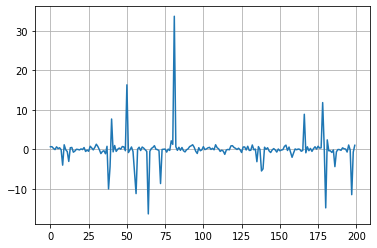

In [4]:
plt.plot(noise)
plt.grid()

#### Зададим параметры входов объекта и смоделируем выход объекта

In [5]:
avg_u1, var_u1 = 0, 10
avg_u2, var_u2 = 1, 50
avg_u3, var_u3 = 0, 1
avg_u4, var_u4 = 5, 50

In [6]:
#Ваш код здесь
np.random.seed(42)
u1 = np.random.normal(avg_u1, var_u1, N)
u2 = np.random.normal(avg_u2, var_u2, N)
u3 = np.random.normal(avg_u3, var_u3, N)
u4 = np.random.normal(avg_u4, var_u4, N)
u_input = [u1, u2, u3, u4]

In [7]:
# моделирование выхода объекта
y = c_params[0] + sum([c*u for c, u in zip(c_params[1::], u_input)]) + noise

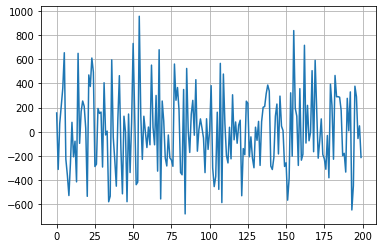

In [8]:
plt.plot(y)
plt.grid()

### Эффективность алгоритма Хубера vs Рекуррентным МНК при различных статистических характеристиках распределений

В лабораторной работе требуется:

1. Реализовать __class Huber__ c методами: <br>
   * в конструкторе класса небходимо задать:<br>
     1) λ в формуле задания начального приближения матрицы Г(0) = λ*I <br>
    2) параметр $ \xi $, участвующий в функции потерь Хьюбера, в зависимости от вероятности появления выброса $ \alpha $ (значения которого приведены в описании ЛР) <br><br>
   *   __def fit(X, y, c0)__ - метод реализует алгоритм итерационного оценивания параметов объекта с использованием функции потерь Хьюбера:<br>
        <br>
        Input:<br>
            X - матрица входов объекта, [X] = m x N <br>
            y - вектор выходов объекта, [y] = N <br>
            с0 - вектор начального приближения, [c0] = m <br>
        <br>       
   * __def get_coefs()__ - метод возвращает массив коэффициентов оценок вектора параметров объекта, получаемого на каждом новом шаге измерений<br>
        <br>
        Output:<br>
            c_estim_huber - массив оценок параметров объекта, полученный в результате работы метода fit<br><br>


In [9]:
class Huber:
    
    def __init__(self, lambda_: float, xi: float):
        self.lambda_ = lambda_
        self.xi = xi
        self.c_estim_huber = []
        
    def fisher_info(self, delta: float, alpha = 0.1, sigma = 0.5):
        from sympy import Symbol, integrate, exp, sqrt, pi
        long1 = (delta/sigma**2)*exp(-delta/sigma**2/(2*sigma**2))/(sigma*sqrt(2*pi))
        long2 = (1 - alpha)*(1/(sqrt(2*pi)*sigma**5))
        var = Symbol('x')
        integral = integrate(var**2*exp(-var**2/(2*sigma**2)),
                             (var, -delta, delta)
                            )
        return 2*(1 - alpha) * long1 / (delta/sigma**2) + long2 * integral
    
    def fit(self, x: List[List], y: List, c0: List):
        self.c_estim_huber = []
        self.c_estim_huber.append(c0)
        G = np.eye(len(x) + 1) * self.lambda_
        sigma = 0.5
        delta = self.xi * sigma
        FI = self.fisher_info(delta).n()
        for i in range(1, len(y)):
            z = np.asmatrix(([1.] + [input[i] for input in u_input])).T
            G = G - G*z*z.T*G/(1/FI.n() + z.T * G * z)
            eps = y[i] - float(z.T*c0)
            if (eps <= -delta):
                d = -delta
            elif (eps >= delta):
                d = delta
            else:
                d = eps
            c0 = c0 + d*G.dot(z)
            self.c_estim_huber.append(c0)

    @property    
    def get_coefs(self) -> List:
        return self.c_estim_huber

In [10]:
huber = Huber(0.1, 1.1)
huber.fit(u_input, y, np.asmatrix(c_params).T)
huber_coef = huber.get_coefs

2. Реализовать __class RecurrentMLS__ с методами: <br>

    * в конструкторе класса небходимо задать:<br>
     1) λ в формуле задания начального приближения матрицы Г(0) = λ*I <br><br>

    * __def fit(X, y, c0)__ - метод реализует алгоритм итерационного оценивания параметов объекта с использованием квадратичной функции потерь (см. 2 лабораторную работу):<br>
         <br>
     Input:<br>
             X - матрица входов объекта, [X] = m x N<br>
             y - вектор выходов объекта, [y] = N<br>
             с0 - вектор начального приближения, [c0] = m+1<br><br>
        
    * __def get_coefs()__ - метод возвращает массив коэффициентов оценок вектора параметров объекта, получаемого на каждом новом шаге измерений<br>
        <br>
        Output:<br>
            c_estim_recMLS - массив оценок параметров объекта, полученный в результате работы метода fit<br><br>        

In [11]:
class RecurrentMLS():
    __slots__ = 'lambda_', 'c_estim_recMLS'

    def __init__(self, lambda_: float):
        self.lambda_ = lambda_
        self.c_estim_recMLS = []
    
    def fit(self, x: List[List], y: List, c0: List):
        self.c_estim_recMLS.append(c0)
        G = self.lambda_ * np.eye(len(x) + 1)
        for i in range(1,len(y)):
            z = np.asmatrix(([1.] + [input[i] for input in u_input])).T
            G = G - G * z * z.T * G/(1 + z.T * G * z)
            c = c0 + G * z * (y[i] - z.T * c0)
            self.c_estim_recMLS.append(c)

    @property
    def get_coefs(self) -> List:
        return self.c_estim_recMLS

In [12]:
recurrentMLS = RecurrentMLS(0.1)
recurrentMLS.fit(u_input, y, np.asmatrix(c_params).T)
recurrentMLS_coefs = recurrentMLS.get_coefs

3. Реализовать функцию __smooth_errors(c_estim, c_true)__  - вычисляет сглаженную ошибку оценки по 10 измерениям. <br>
         Input: 
             c_estim - массив оценок параметров объекта, [c_estim] = m+1 x N
             c_true - вектор истинных параметров объекта, [c_true] = m+1 
         Output:
             err - массив сглаженных ошибок оценки
              
4. Провести исследование эффективности алгоритма Хубера по сравнению с рекуррентным МНК алгоритмом при следующих статистических характеристиках распределений:<br>
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.1    $\sigma_\eta (outlier)$ = 10;
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.1    $\sigma_\eta (outlier)$ = 50;
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.1    $\sigma_\eta (outlier)$ = 100;
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.3    $\sigma_\eta (outlier)$ = 10;
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.3    $\sigma_\eta (outlier)$ = 50;
    * $ \sigma_\eta $ = 0.5    $\alpha$ = 0.3    $\sigma_\eta (outlier)$ = 100. <br><br>
5. Построить графики сходимости сглаженной ошибки оценки по двум алгоритмам: алгоритм с использованием теоремы Хубера и рекуррентный алгоритм, соответствующий методу наименьших квадратов. Сдалать выводы.

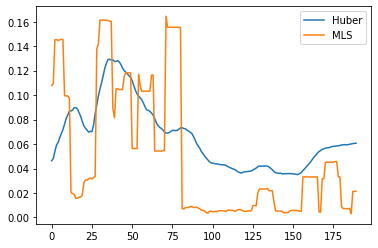

In [13]:
def smooth_errors(c_estim: List, c_true: List):
    root_mse = []
    for i in range(10, len(c_estim)):
        mse = 0
        for j in range(10):
            for k in range(4):
                mse += (float(c_estim[i - j][k]) - float(c_true[k]))**2
        root_mse.append((mse/10)**0.5)
    return root_mse

errors_1 = smooth_errors(huber_coef, c_params)
errors_2 = smooth_errors(recurrentMLS_coefs, c_params)
t = [i for i in range(10,200)]

plt.plot(errors_1, label='Huber')
plt.plot(errors_2, label='MLS')
plt.legend()

### Hints

1. Рекуррентный алгоритм при функции потерь Хьюбера имеет вид:
\begin{equation} \large \hat{\vec{c}}(i)=\hat{\vec{c}}(i-1)+Г(i)d(\varepsilon(i, \hat{\vec{c}}(i-1)))\vec{z}(i) \\
\large Г(i)=Г(i-1)-\frac{Г(i-1)\vec{z}(i)\vec{z}(i)^TГ(i-1)}{I^{-1}_F+\vec{z}^T(i)Г(i-1)\vec{z}(i)} \\
\large Г(0)=\lambda I, \lambda >> 1,  \hat{\vec{c}}(0)=\vec{c}_{0}\end{equation}

где $ \large  \Delta = \xi\sigma_\eta$
\begin{equation} \large d(\varepsilon(i, \hat{\vec{c}}(i-1)))=\frac{dF(\varepsilon(i, \hat{\vec{c}}(i-1)))}{d\varepsilon}|_{\varepsilon = \varepsilon(i, \hat{\vec{c}}(i-1)))}= \left\{
    \begin{array}\\
        -\Delta, & \varepsilon(i) \leq -\Delta \\
        \varepsilon(i, \hat{\vec{c}}(i-1))), & -\Delta \leq |\varepsilon(i)| \leq \Delta\\
        \Delta, &  \varepsilon(i) \geq \Delta
    \end{array}  
\right.\end{equation}

\begin{equation} \large  I_F=2(1-\alpha)\frac{\Delta}{\sigma^2_\eta}f_N(\frac{\Delta}{\sigma_\eta})+(1-\alpha)\frac{1}{\sqrt{2\pi}\sigma_\eta}\frac{1}{\sigma^4_\eta}\int_{-\Delta}^\Delta \eta^2exp(\frac{-\eta^2}{2\sigma^2_\eta})d\eta\end{equation}

2. Для вычислении информации Фишера можно использовать модуль __sympy__ (https://docs.sympy.org/latest/modules/integrals/integrals.html)